In [1]:
# # this block of code imports graphical libraries for plotting graphs with high resolution
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 120

In [13]:
# Libraries of functions need to be imported
import numpy as np
import pandas as pd
from xgboost import XGBRegressor
from sklearn import linear_model
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler, MinMaxScaler, QuantileTransformer
from scipy.spatial import Delaunay
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import mean_squared_error
from scipy import linalg
from scipy.interpolate import interp1d, LinearNDInterpolator, NearestNDInterpolator
from sklearn.decomposition import PCA

from scipy.spatial.distance import cdist

# the following line(s) are necessary if you want to make SKlearn compliant functions
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted

## Question 1

In [4]:
# Gaussian Kernel
def Gaussian(x):
  return np.where(np.abs(x)>4,0,1/(np.sqrt(2*np.pi))*np.exp(-1/2*x**2))

In [20]:
# Epanechnikov Kernel
def Epanechnikov(x):
  return np.where(np.abs(x)>1,0,3/4*(1-np.abs(x)**2))

In [5]:
def weight_function(u,v,kern=Gaussian,tau=0.5):
    return kern(cdist(u, v, metric='euclidean')/(2*tau))

Lowess Class

In [7]:
class Lowess:
    def __init__(self, kernel=Gaussian, tau=0.05):
        self.kernel = kernel
        self.tau = tau

    def fit(self, x, y):
        self.xtrain_ = x
        self.yhat_ = y

    def predict(self, x_new):
        x = self.xtrain_
        y = self.yhat_
        lm = Ridge(alpha=0.001)
        w = weight_function(x, x_new, self.kernel, self.tau)

        if np.isscalar(x_new):
            lm.fit(np.diag(w) @ (x.reshape(-1, 1)), np.diag(w) @ (y.reshape(-1, 1)))
            yest = lm.predict([[x_new]])[0][0]
        else:
            n = len(x_new)
            yest_test = []
            for i in range(n):
                lm.fit(np.diag(w[:, i]) @ x, np.diag(w[:, i]) @ y)
                yest_test.append(lm.predict([x_new[i]]))
            return np.array(yest_test).flatten()


Gradient Boosting with user-prescribed number of boosting steps

In [26]:
class GradientBoostingLowess:
    def __init__(self, n_estimators=100, learning_rate=0.1, kernel1=Epanechnikov, tau1=0.14, kernel2=Gaussian, tau2=0.2):
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.models = []
        self.kernel1 = kernel1
        self.tau1 = tau1
        self.kernel2 = kernel2
        self.tau2 = tau2

    def fit(self, X, y):
        self.models = []
        y_pred = np.zeros_like(y)

        for _ in range(self.n_estimators):
            model1 = Lowess(kernel=self.kernel1, tau=self.tau1)
            model1.fit(X, y_pred)
            y_hat_train = model1.predict(X)
            residuals_train = y - y_hat_train

            model2 = Lowess(kernel=self.kernel2, tau=self.tau2)
            model2.fit(X, residuals_train)
            self.models.append((model1, model2))

    def predict(self, X):
        y_pred = np.zeros(X.shape[0])
        for model1, model2 in self.models:
            y_pred += self.learning_rate * (model1.predict(X) + model2.predict(X))
        return y_pred

    def is_fitted(self):
        return len(self.models) > 0


Loading in Data

In [76]:
data = pd.read_csv('/content/concrete.csv')
X = data.drop(columns = ['strength']).values
y = data['strength'].values

Define Scalars

In [11]:
scalers = {
    'StandardScaler': StandardScaler(),
    'MinMaxScaler': MinMaxScaler(),
    'QuantileTransformer': QuantileTransformer()
}

In [27]:
gb_lowess = GradientBoostingLowess(n_estimators=10, learning_rate=0.1)

# Perform 10-fold cross-validation and compare different scalers
for scaler_name, scaler in scalers.items():
    kf = KFold(n_splits=10)
    mse_scores = []
    counter = 0

    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Scale data
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        # Fit model
        gb_lowess.fit(X_train_scaled, y_train)
        counter +=1
        print(counter)
        # Predict
        y_pred = gb_lowess.predict(X_test_scaled)

        # Calculate MSE
        mse = mean_squared_error(y_test, y_pred)
        mse_scores.append(mse)

    print(f'MSE scores with {scaler_name}: {mse_scores}')
    print(f'Average MSE with {scaler_name}: {np.mean(mse_scores)}')

1
2
3
4
5
6
7
8
9
10
MSE scores with StandardScaler: [1329.6725073879772, 1342.2428751583866, 212.18032112959173, 912.2209042101563, 958.346399747072, 90.05207186425771, 308.59852748278377, 508.73438050412597, 75.34762220861997, 14.736889498152522]
Average MSE with StandardScaler: 575.2132499191124
1
2
3
4
5
6
7
8
9
10
MSE scores with MinMaxScaler: [199.24843258291466, 131.0637079571976, 59.55365609276102, 132.5788183541165, 97.32073973711134, 41.73766470934508, 48.893442498692345, 43.816254109755974, 33.819751551631256, 32.29421299593331]
Average MSE with MinMaxScaler: 82.03266805894592


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (927). n_quantiles is set to n_samples.
  warnings.warn(


1


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (927). n_quantiles is set to n_samples.
  warnings.warn(


2


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (927). n_quantiles is set to n_samples.
  warnings.warn(


3


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (927). n_quantiles is set to n_samples.
  warnings.warn(


4


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (927). n_quantiles is set to n_samples.
  warnings.warn(


5


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (927). n_quantiles is set to n_samples.
  warnings.warn(


6


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (927). n_quantiles is set to n_samples.
  warnings.warn(


7


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (927). n_quantiles is set to n_samples.
  warnings.warn(


8


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (927). n_quantiles is set to n_samples.
  warnings.warn(


9


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (927). n_quantiles is set to n_samples.
  warnings.warn(


10
MSE scores with QuantileTransformer: [103.21518660527974, 79.22675788404666, 36.438570886724, 90.59107463553279, 80.49995187647919, 54.45814586945954, 25.45322357711788, 21.936527274860826, 20.61380282894073, 26.824807552938168]
Average MSE with QuantileTransformer: 53.92580489913796


In [37]:
xgb_model = XGBRegressor(objective ='reg:squarederror',n_estimators=10,reg_lambda=20,alpha=1,gamma=10,max_depth=3)

# Perform 10-fold cross-validation with XGBoost
xgb_mse_scores = []

for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Fit model
    xgb_model.fit(X_train, y_train)

    # Predict
    y_pred = xgb_model.predict(X_test)

    # Calculate MSE
    mse = mean_squared_error(y_test, y_pred)
    xgb_mse_scores.append(mse)

print(f'MSE scores with XGBoost: {xgb_mse_scores}')
print(f'Average MSE with XGBoost: {np.mean(xgb_mse_scores)}')

MSE scores with XGBoost: [70.53647163005765, 191.0514395491261, 44.13326928550733, 124.66897602548669, 83.61695799540676, 56.281943863519786, 56.648937537416145, 79.16114945571937, 61.40560626161717, 52.68090160887271]
Average MSE with XGBoost: 82.01856532127297


While using the same amount of boosting steps in my class and the XGBRegressor, my class yields lowers MSE's.\
The hyperparameters for my class are:
- n_estimators = 10
- learning_rate = 0.1
- kernel1 = Epanechnikov
- tau1 = 0.14
- kernel2 = Gaussian
- tau2 = 0.2

## Question 2

In [38]:
!pip install numpy usearch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 22.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 70.4 MB/s eta 0:00:00


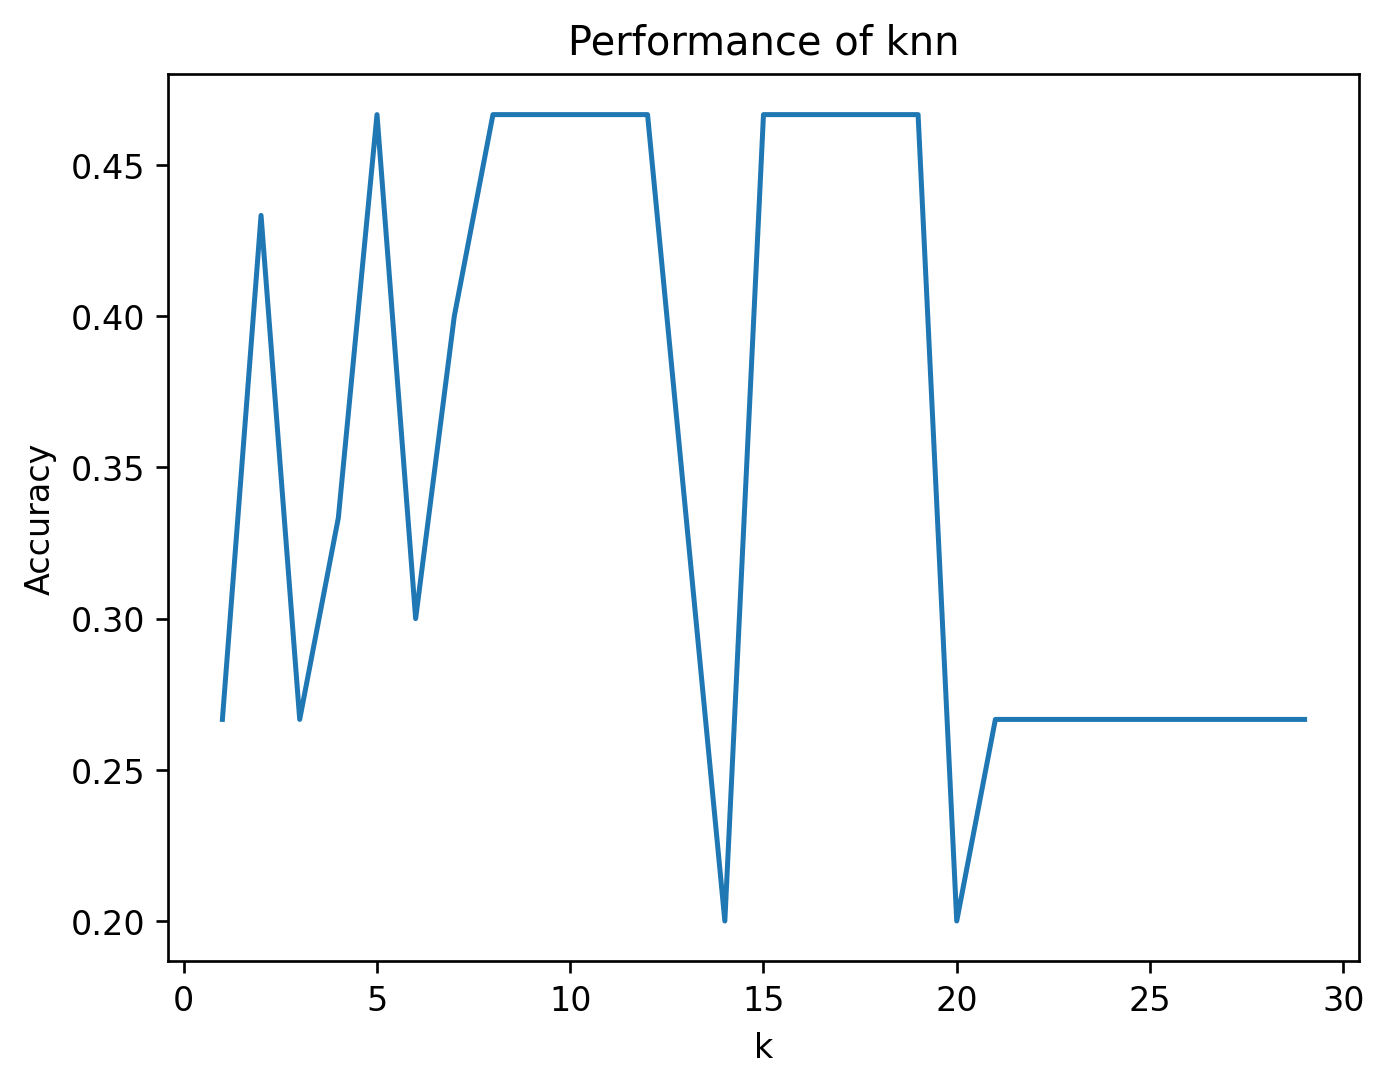

In [106]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from usearch.index import search, MetricKind

def most_common(lst):
    unique, counts = np.unique(lst, return_counts=True)
    max_count = np.max(counts)
    most_common_labels = unique[counts == max_count]
    return most_common_labels[0] if len(most_common_labels) == 1 else most_common_labels[np.random.randint(len(most_common_labels))]

class KNeighborsClassifier:
    def __init__(self, k=5):
        self.k = k

    def fit(self, X_train, y_train):
        self.X_train = X_train
        self.y_train = y_train

    def predict(self, X_test):
        neighbors = []
        for x in X_test:
            distances = search(self.X_train, x, self.k, MetricKind.L2sq, exact=True).distances
            nearest_indices = np.argsort(distances)
            nearest_labels = self.y_train[nearest_indices]
            neighbors.append(nearest_labels)
        return np.array(list(map(most_common, neighbors)))

    def evaluate(self, X_test, y_test):
        y_pred = self.predict(X_test)
        accuracy = np.sum(y_pred == y_test) / len(y_test)
        return accuracy

# Unpack the iris dataset
iris = datasets.load_iris()
X = iris['data']
y = iris['target']

# Split data into train & test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Preprocess data
ss = StandardScaler().fit(X_train)
X_train, X_test = ss.transform(X_train), ss.transform(X_test)

# Test knn model across varying ks
accuracies = []
ks = range(1, 30)
for k in ks:
    knn = KNeighborsClassifier(k=k)
    knn.fit(X_train, y_train)
    accuracy = knn.evaluate(X_test, y_test)
    accuracies.append(accuracy)

# Visualize accuracy vs. k
fig, ax = plt.subplots()
ax.plot(ks, accuracies)
ax.set(xlabel="k",
       ylabel="Accuracy",
       title="Performance of knn")
plt.show()


## Question 3

https://akhipath03.github.io/AdvMachineLearning/HW1/